In [106]:
import timm

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [137]:
from pathlib import Path


class GLDConfig:
    home_path = Path('/root/kaggle/google-retrieval')
    pretrained_path = home_path/'weight/resnet50-epoch=23-fold0-val_loss=3.8455.ckpt'

    seed = 42
    thres = 0.5
    num_workers = 8

    backbone_name = "tf_efficientnet_b4_ns"
    gd_config = 'SG'
    feature_dim = 1536
    global_only = True
    random_gamma_rescale = False
    reduced_dim = 128

    data_root = Path('/shared/lorenzo/data-gld')
    split_df_root = home_path/'split'
    fold_no = 0
    aug = True
    img_size = 384
    img_scales = [1.0]
    num_classes = 81313

    batch_size = 1

    top_k = 100

    lr = 1e-3
    optimizer='adamw'
    smoothing : 0.1
    temperature : 0.5
    margin : 0.1

    weight_path = home_path/'pl_output/resnet50-epoch=23-fold0-val_loss=3.8455.ckpt'
    output_dir = home_path/'weight'
    smoothing = 0.1
    temperature = 0.5
    margin = 0.1

    device = 'cuda:2'

config = GLDConfig

In [6]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from dataset import GLDataset

transform = A.Compose([
                A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=10, border_mode=0, p=0.7),
                A.RandomResizedCrop(config.img_size, config.img_size),
                A.HorizontalFlip(p=0.5),
                A.Normalize(),
                ToTensorV2(p=1.0),
            ])

dataset = GLDataset(root=config.data_root, fold_no=config.fold_no,
                    split_df_root=config.split_df_root, split='train', transform=transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 224, 224])

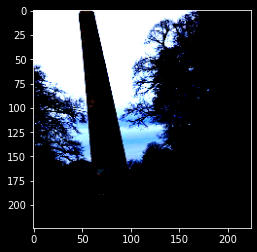

In [49]:
import matplotlib.pyplot as plt

img, label = dataset[2]
plt.imshow(img.permute(1,2,0))

img = img.unsqueeze(0).to(config.device)
img.shape

In [152]:
from module.utils import get_in_features

def set_bn_eval(m):
    classname = m.__class__.__name__
    if classname.find('BatchNorm') != -1:
        m.eval()

class GlobalDescriptor(nn.Module):
    def __init__(self, p=1):
        super().__init__()
        self.p = p

    def forward(self, x):
        assert x.dim() == 4, 'the input tensor of GlobalDescriptor must be the shape of [B, C, H, W]'
        if self.p == 1:
            return x.mean(dim=[-1, -2])
        elif self.p == float('inf'):
            return torch.flatten(F.adaptive_max_pool2d(x, output_size=(1, 1)), start_dim=1)
        else:
            sum_value = x.pow(self.p).mean(dim=[-1, -2])
            return torch.sign(sum_value) * (torch.abs(sum_value).pow(1.0/self.p))

    def extra_repr(self):
        return f"p={self.p}"


class L2Norm(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        assert x.dim() == 2, 'the input tensor of L2Norm must be the shape of [B, C]'
        return F.normalize(x, p=2, dim=-1)


class CGD(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.backbone_name = config.backbone_name
        gd_config = config.gd_config
        feature_dim = config.feature_dim
        num_classes = config.num_classes

        # Get backbone
        backbone = timm.create_model(
            self.backbone_name,
            pretrained=True,
            num_classes=0,
            global_pool='',
        )

        self.features = backbone
        
        in_features = get_in_features(self.backbone_name)

        # Main Module
        n = len(gd_config)
        k = feature_dim // n
        assert feature_dim % n == 0, 'the feature dim should be divided by number of global descriptors'

        self.global_descriptors, self.main_modules = [], []
        for i in range(n):
            if gd_config[i] == 'S':
                p = 1
            elif gd_config[i] == 'M':
                p = float('inf')
            else:
                p = 3
            self.global_descriptors.append(GlobalDescriptor(p=p))
            self.main_modules.append(nn.Sequential(nn.Linear(in_features, k, bias=False), L2Norm()))
        self.global_descriptors = nn.ModuleList(self.global_descriptors)
        self.main_modules = nn.ModuleList(self.main_modules)


        # Auxiliary Modules
        self.auxiliary_module = nn.Sequential(
            nn.BatchNorm1d(in_features),
            nn.Linear(in_features, num_classes, bias=True)
        )

    def forward(self, x):
        shared = self.features(x)
        global_descriptors = []
        for i in range(len(self.global_descriptors)):
            global_descriptor = self.global_descriptors[i](shared)
            if i == 0:
                classes = self.auxiliary_module(global_descriptor)
            global_descriptor = self.main_modules[i](global_descriptor)
            global_descriptors.append(global_descriptor)
        global_descriptors = F.normalize(torch.cat(global_descriptors, dim=-1), dim=-1)
        return shared, global_descriptors, classes

model = CGD(config)
model.to(config.device)
model.train()

CGD(
  (features): EfficientNet(
    (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (act1): SiLU(inplace=True)
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
          (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act1): SiLU(inplace=True)
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running

In [153]:
img = torch.rand((1, 3, 384, 384)).to(GLDConfig.device)

In [154]:
model.apply(set_bn_eval)
stage4, g_features, classes = model(img)
stage4.shape, g_features.shape, classes.shape

RuntimeError: running_mean should contain 1792 elements not 2048